In [297]:
import os
os.chdir('/home/sin/p/code/jupyter-notebook/V-COCO')
import numpy as np
import json
import pandas as pd
from pathlib import Path
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import vsrl_utils as vu

PATH = '/home/sin/p/code/jupyter-notebook/V-COCO/data/vcoco'
PATH = Path(PATH)
IMG = '/home/sin/p/dataset/V-COCO'
IMG = Path(IMG)

# Load COCO annotations for V-COCO images
coco = vu.load_coco()

# Load the VCOCO annotations for vcoco_train image set
file_names = ['vcoco_train', 'vcoco_val', 'vcoco_test']
vcocos = {}

for file_name in file_names:
    vcocos[file_name] = vu.load_vcoco(file_name)
    for x in vcocos[file_name]:
        x = vu.attach_gt_boxes(x, coco)

In [382]:
class MyVCOCO:
    def __init__(self, type:str):
        # Load COCO annotations for V-COCO images
        self.coco = vu.load_coco()
        self.vcoco = vu.load_vcoco(type)
        for x in self.vcoco:
            x = vu.attach_gt_boxes(x, self.coco)

        self.role_list = None

    def getTarget(self, vcoco) -> np.array:
        target = vcoco['label'].ravel()
        target = np.where(target == 1)[0]
        return target

    def getAction(self, vcoco) -> np.array:
        return vcoco['action_name']


    def getRoleObjExPerson(self, vcoco, target):
        return vcoco['role_object_id'][target][:,1:]


    def getRoleId2ObjName(self, ret):
        def f(x):
            # print(x)
            if x != 0:
                name = coco.cats[coco.loadAnns(x)[0]['category_id']]['name']
                return name
            return 'not-bbox'

        ret['obj'] = ret['obj'].apply(f)

        return ret


    def getRoleNameExPerson(self, vcoco, target):
        return vcoco['role_name'][1:]


    def getImageID(self, vcoco, target):
        img_id = vcoco['image_id'][target].ravel().tolist()
        img_id = coco.loadImgs(img_id)
        img_id = [id['file_name'] for id in img_id]
        return img_id


    def getRoleList(self, ret, vcoco, target):
        role_list = self.getRoleObjExPerson(vcoco, target) # 사람 객체 제외
        role_names = self.getRoleNameExPerson(vcoco, target) # 사람 객체 제외
        action = self.getAction(vcoco)
        img_ids = self.getImageID(vcoco, target)

        for ind in range(len(role_names)):
            _ret = pd.DataFrame()

            act = action
            act += '-'
            act += role_names[ind]
            obj = role_list[:,ind]

            # print(act)
            # print(val)

            _ret['obj'] = obj
            _ret['action'] = act
            _ret['img_id'] = img_ids
            ret = ret.append(_ret, ignore_index=True)

        # print(ret)
        return ret

    def maskDF(self):
        self.role_list = pd.DataFrame()

        for coco_per_verb in self.vcoco:
            # print(coco_per_verb)
            # print(coco_per_verb.keys())
            target = self.getTarget(coco_per_verb)
            self.role_list = self.getRoleList(self.role_list, coco_per_verb, target)

        self.role_list = self.getRoleId2ObjName(self.role_list)
        # print(role_list)

        return self.role_list



train_vcoco = MyVCOCO('vcoco_train')
train_df = train_vcoco.maskDF()

val_vcoco = MyVCOCO('vcoco_val')
val_df = val_vcoco.maskDF()

test_vcoco = MyVCOCO('vcoco_test')
test_df = test_vcoco.maskDF()

In [383]:
train_df

,obj,action,img_id
0,surfboard,hold-obj,COCO_train2014_000000226162.jpg
1,cup,hold-obj,COCO_train2014_000000210751.jpg
2,not-bbox,hold-obj,COCO_train2014_000000433398.jpg
3,fork,hold-obj,COCO_train2014_000000054995.jpg
4,knife,hold-obj,COCO_train2014_000000078578.jpg
...,...,...,...
8479,snowboard,snowboard-instr,COCO_train2014_000000206349.jpg
8480,not-bbox,snowboard-instr,COCO_train2014_000000250026.jpg
8481,snowboard,snowboard-instr,COCO_train2014_000000109872.jpg
8482,snowboard,snowboard-instr,COCO_train2014_000000367850.jpg


In [351]:
train_count = train_df['action'].value_counts()
val_count = val_df['action'].value_counts()
test_count = test_df['action'].value_counts()

hold-obj                  1838
look-obj                  1770
sit-instr                  935
jump-instr                 319
eat-instr                  301
eat-obj                    301
ride-instr                 252
lay-instr                  243
surf-instr                 239
carry-obj                  236
skateboard-instr           220
work_on_computer-instr     210
ski-instr                  190
snowboard-instr            176
talk_on_phone-instr        167
hit-obj                    164
hit-instr                  164
throw-obj                  159
catch-obj                  152
cut-obj                    127
cut-instr                  127
kick-obj                    65
drink-instr                 63
read-obj                    51
point-instr                 15
Name: action, dtype: int64

In [411]:
all_act_count = \
    pd.DataFrame({'train':train_count, 'val':val_count, 'test':test_count})\
    .sort_values(by='train',ascending=False)
all_act_count.to_csv('all_obj_count.csv')

In [408]:
all_obj_count_per_act = pd.DataFrame()

print(train_df['action'].unique())
for act in train_df['action'].unique():
    all_obj_count_per_act.loc[act,'train'] = \
        len(train_df[train_df['action'] == act]['obj'].unique())

    all_obj_count_per_act.loc[act,'val'] = \
        len(val_df[val_df['action'] == act]['obj'].unique())

    all_obj_count_per_act.loc[act,'test'] = \
        len(test_df[test_df['action'] == act]['obj'].unique())


all_obj_count_per_act.astype({'train':int,'val':int,'test':int})\
    .sort_values('train', ascending=False).to_csv('obj_count_per_act.csv')

['hold-obj' 'sit-instr' 'ride-instr' 'look-obj' 'hit-instr' 'hit-obj'
 'eat-obj' 'eat-instr' 'jump-instr' 'lay-instr' 'talk_on_phone-instr'
 'carry-obj' 'throw-obj' 'catch-obj' 'cut-instr' 'cut-obj'
 'work_on_computer-instr' 'ski-instr' 'surf-instr' 'skateboard-instr'
 'drink-instr' 'kick-obj' 'point-instr' 'read-obj' 'snowboard-instr']


In [405]:

(all_act_count/all_obj_count_per_act).astype({'train':int,'val':int,'test':int})\
    .sort_values('train', ascending=False).to_csv('divided_obj.csv')




000000492769.jpg
407
000000492769.jpg
cut
['agent', 'instr', 'obj']
[ 221285  697503 1074932]
['person', 'knife', 'pizza']
[[396.21, 141.05, 243.79, 206.8], [352.65, 195.56, 134.1, 70.1], [234.61, 283.15, 186.87, 73.61]]


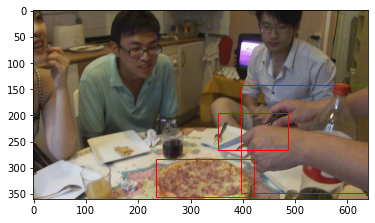

In [92]:
cc = plt.get_cmap('hsv', lut=4)

def sortValue(classAnno):
    target = np.array(classAnno['label'])
    target = np.where(target == 1)[0]
    target = np.random.choice(target)
    # target = 101

    action_name = classAnno['action_name']
    role_name = classAnno['role_name']
    img_id = classAnno['image_id'][target]
    img_id = coco.loadImgs(img_id)[0]['file_name'].split('_')[2]

    print(img_id)
    print(target)
    print(img_id)
    print(action_name)
    print(role_name)


    role_obj_id = classAnno['role_object_id'][target]
    print((role_obj_id))
    role_obj_id = [i for i in role_obj_id if i != 0]
    role_information = coco.loadAnns(role_obj_id)
    print([coco.cats[i['category_id']]['name'] for i in role_information])
    bbox = [i['bbox'] for i in role_information]
    print(bbox)



    image_path = str(list(IMG.glob(f'*2017/*{img_id}*'))[0])
    # print(image_path)
    plt.figure()
    ax = plt.gca()
    image = plt.imread(image_path)
    plt.imshow(image)

    # bbox = bbox.astype(np.int)
    for roi in bbox:
        # ax.add_patch(plt.Rectangle((roi[0], roi[1]),
        #             roi[2] - roi[0], roi[3] - roi[1],
        #             fill=False, linewidth=1, edgecolor=cc(0)[:3]))
        ax.add_patch(plt.Rectangle((roi[0], roi[1]),
                    roi[2], roi[3],
                    fill=False, linewidth=1, edgecolor=cc(0)[:3]))

sortValue(vcoco_all[14])

In [93]:
ret = pd.DataFrame()

for vcoco in vcoco_all:
    target = np.array(vcoco['label'])
    target = np.where(target == 1)[0]
    # print(target)
    # print(vcoco)
    action = vcoco['action_name']
    role_name = vcoco['role_name']
    # print(action)
    # print(role_name)

    # print(len(vcoco['image_id'][target]))
    role_obj_id = vcoco['role_object_id'][target]

    # print(role_obj_id)
    # print(role_obj_id[:,1:])

    role_name = role_name[1:]
    role_obj_id = role_obj_id[:,1:]
    # print(role_name)
    # print(role_obj_id)

    for ind in range(len(role_name)):
        col = role_name[ind]
        val = role_obj_id[:,ind]
        # print(val)
        _ret =  pd.DataFrame({'id':val})
        _ret['action'] = action+'_'+col

        ret = ret.append(_ret, ignore_index=True)

ret

#

,id,action
0,1185963,hold_obj
1,14607,hold_obj
2,1186273,hold_obj
3,0,hold_obj
4,322643,hold_obj
...,...,...
9900,616032,snowboard_instr
9901,616797,snowboard_instr
9902,618316,snowboard_instr
9903,616229,snowboard_instr
